In [100]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append("../..")


import neuroprob as mdl
from neuroprob import utils

import utils_func

dev = utils.pytorch.get_device()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.8.0+cu111
Using device: cuda:0


In [22]:
import importlib
import neuroprob.utils

In [33]:
importlib.reload(neuroprob.utils)
# import neuroprob.utils
from neuroprob import utils

In [2]:
import os
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis\\notebook\\CA_precession'

In [4]:
os.chdir('..')
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis'

### Verification of Kempter regression and corr coefficient

change
0.09644384682178497 1.0668407771494461


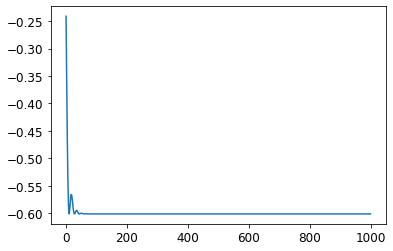

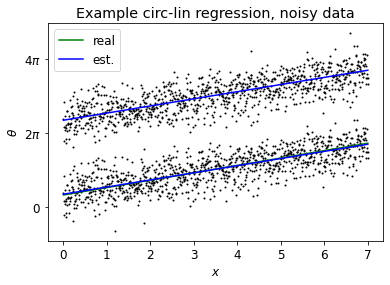

In [30]:
# Try using bivariate Gaussian
x = np.linspace(0, 7, 1000)
ra = 0.1
rshift = 1
theta = (2*np.pi*ra*x + rshift) + np.random.randn(1000)
theta = np.append(theta, theta + 2*np.pi)
x = np.append(x,x)

line, a, shift, losses = utils.latent.circ_lin_regression(theta, x, dev='cpu', iters=1000, lr=1e-2)
print(a, shift)
plt.plot(losses)
plt.show()

fig = plt.figure()
plt.plot(x, theta, 'o', ms=1, c='k')
plt.plot(x, 2*np.pi*ra*x + rshift, 'g', label='real')
plt.plot(x, 2*np.pi*a*x + shift, 'b', label='est.')
plt.plot(x, 2*np.pi*a*x + shift + 2*np.pi, 'b')
plt.title("Example circ-lin regression, noisy data")
plt.ylabel(r'$\theta$')
plt.xlabel(r'$x$')
plt.yticks(ticks=[0,2*np.pi, 4*np.pi], labels=[r'$0$', r'$2\pi$', r'$4\pi$'])
plt.legend()
plt.show()

In [35]:
r_F = np.zeros(20)
r_K = np.zeros(20)
ns = np.logspace(1,6,20)
for i, n in enumerate(ns):
    x = np.linspace(0, 7, int(n/2))
    ra = 0.1
    rshift = 1
    theta = 2*np.pi*ra*x + rshift
    theta = np.append(theta, theta + 2*np.pi)
    x = np.append(x, x)

    line, a, shift, losses = utils.latent.circ_lin_regression(theta, x, dev='cpu', iters=500, lr=1e-2)
#     print(a, shift)
#     plt.plot(losses)

    r_F[i] = utils.stats.corr_lin_circ(x, theta)
    r_K[i] = utils.stats.corr_lin_circ_Kempter(x, theta, a)


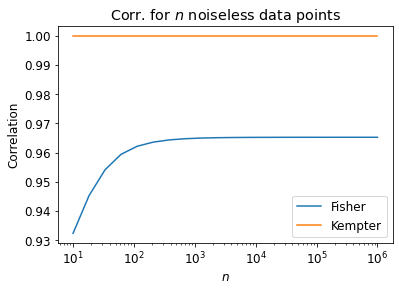

In [33]:
fig = plt.figure()
plt.semilogx(ns, r_F, label='Fisher')
plt.semilogx(ns, r_K, label='Kempter')
plt.title(r'Corr. for $n$ noiseless data points')
plt.ylabel("Correlation")
plt.xlabel(r'$n$')
plt.legend()
plt.show()

In [34]:
fig.savefig("output/corr_Fisher_Kempter.svg", bbox_inches='tight')

### Loading data

In [37]:
# loading data
dataset = 'hc3'
session_id = 'ec014.468'

data = np.load('./saves/{}_{}.npz'.format(dataset, session_id))
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
eeg_t = data['eeg_t']
sample_bin = data['sample_bin']

units = spktrain.shape[0]

In [7]:
sep_t_spike = []
for k in range(units):
    sep_t_spike.append(neural_utils.BinToTrain(spktrain[k]))
    
ISI, LV = neural_utils.compute_ISI_LV(sample_bin, sep_t_spike) # compute ISIs and bursting coefficient

../..\neuroprob\neural_utils.py:102: RuntimeWarning: Mean of empty slice.
  LV.append( 3 * (((ISI_[:-1] - ISI_[1:]) / (ISI_[:-1] + ISI_[1:]))**2).mean() )
C:\Users\Mattijs\Anaconda3\envs\comp-neuro\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
c_x_t = utils_func.class_x_t(x_t)
dir_t = utils_func.L_R_run(c_x_t)
ind_L_R = np.where(dir_t == -1)
ind_R_L = np.where(dir_t == 1)
ind_stat = np.where(dir_t == 0)

# incompleted runs:  1


In [39]:
# Taken from analysis-hc3
unit_used = np.array([11, 20, 44, 56, 66, 68], dtype=int)
spktrain_L_R = np.squeeze(spktrain[unit_used][:,ind_L_R])
x_t_L_R = x_t[ind_L_R]
theta_t_L_R = theta_t[ind_L_R]

In [40]:
lims_L_R = {11: [(50, 125)], 20: [(175, 250)], 33: [(50, 125)],
            34: [(125, 275)], 42:[(150, 225), (225, 300)], 43: [(50, 100)],
            44: [(225, 275)], 56: [(200, 275)], 64: [(100, 175), (175, 275)],
            66:[(75, 175), (175, 250)], 68:[(75, 175)], 69: [(175, 275)],
            70:[(75, 150)], 71: [(100, 150)], 79: [(50, 150)], 41:[(0,300)]}

change
change
change
change
change
change
change


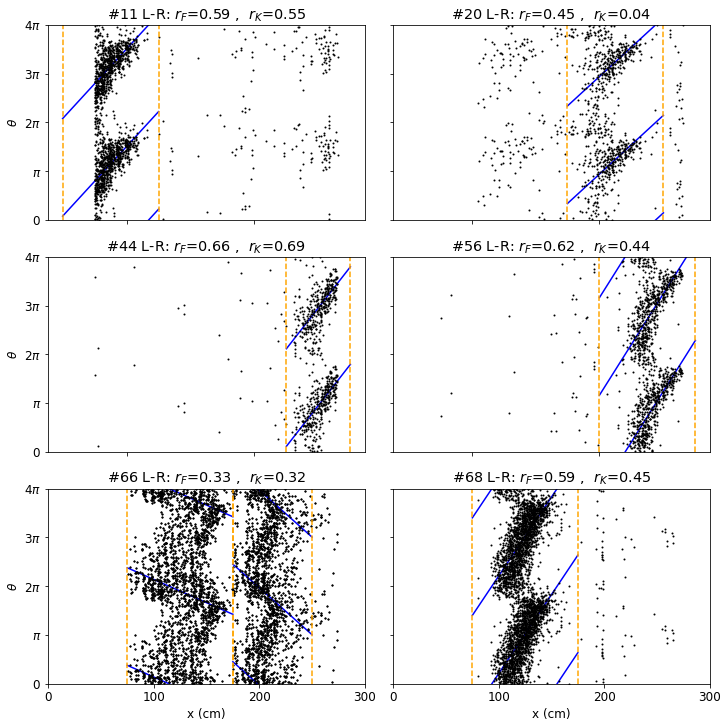

In [42]:
H, W = 3, 2
fig, ax = plt.subplots(H, W, squeeze=True, sharex=True, sharey=True, figsize=(10, 10),constrained_layout=True)

for nn in range(W*H):
    for limit in lims_L_R[unit_used[nn]]:
        all_spikes = spktrain_L_R[nn].astype(bool)
        t_spikes = spktrain_L_R[nn].astype(bool) & (x_t_L_R > limit[0]) & (x_t_L_R < limit[1])
        x = np.linspace(limit[0], limit[1], 1000)
        
        # Find regression line and plot it
        line, a, shift, losses = utils.latent.circ_lin_regression(theta_t_L_R[t_spikes], x_t_L_R[t_spikes], dev='cpu', iters=1000, lr=1e-4)
        [ax[nn // W,nn % W].plot(x, 2*np.pi*x*a + shift + k*2*np.pi, c='b') for k in range(-5,5)]
        
        # Plot spikes
        ax[nn // W,nn % W].plot(x_t_L_R[all_spikes], theta_t_L_R[all_spikes], 'o', ms=1, c='k')
        ax[nn // W,nn % W].plot(x_t_L_R[all_spikes], theta_t_L_R[all_spikes]+2*np.pi, 'o', ms=1, c='k')
        
        # Plot limits
        ax[nn // W,nn % W].axvline(limit[0], ls='--', c='orange')
        ax[nn // W,nn % W].axvline(limit[1], ls='--', c='orange')
        
        r_F = utils.stats.corr_lin_circ(x_t_L_R[t_spikes], theta_t_L_R[t_spikes])
        r_K = utils.stats.corr_lin_circ_Kempter(x_t_L_R[t_spikes], theta_t_L_R[t_spikes], a)
    
    ax[nn // W,nn % W].set_ylim(0,4*np.pi)
    ax[nn // W,nn % W].set_title(r'#{} L-R: $r_F$={:.2f} ,  $r_K$={:.2f}'.format(unit_used[nn], r_F, r_K))

side = np.arange(H)
[ax[s, 0].set_ylabel(r'$\theta$') for s in np.arange(H)]
[ax[s, 0].set_yticks(np.arange(0, 4*np.pi+1e-3, np.pi))  for s in np.arange(H)]
[ax[s, 0].set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])  for s in np.arange(H)]
[ax[2, s].set_xlabel('x (cm)')  for s in np.arange(W)]
[ax[2, s].set_xticks(np.arange(0, 301, 100))  for s in np.arange(W)]

plt.show()

# fig.savefig("output/spikes_corr_regr_6.svg", bbox_inches='tight')

### Compare with GP

In [49]:
def setup_GP_2D(x_ts, theta_ts, spikes, left_x, right_x, dt, batch_size, lr):
    neurons, sim_samples = np.shape(spikes)
    # GP rate model
    l_spat = 1.*np.array([np.ones(neurons)])
    l_ang = 0.1*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    kernels_tuples = [('variance', v), ('Matern32', 'euclid', l_spat), ('Matern32', 'torus', l_ang)]
    VI_tuples = [(None, None, None, 1), (None, None, None, 1)]

    num_induc = 20
    inducing_points = np.array([np.linspace(left_x, right_x, num_induc), 
                                np.random.rand(num_induc)*2*np.pi]).T[None, :, :].repeat(neurons, axis=0)
    # repeat to get separate inducing points per neuron

    rate_model = mdl.nonparametrics.Gaussian_process(
        neurons, # number of neurons
        inducing_points, # initial inducing points
        kernels_tuples, # kernels
        VI_tuples, # prior and variational distributions
        shared_kernel_params=False, # share all kernel parameters over neurons?
        cov_type='factorized', # fit with full GP posterior covariance?
        mean=0.*np.ones((neurons)), # initial GP mean, learnable
        inv_link='exp', # inverse link function
        whiten=True # use whitened representation
    )
    rate_model.set_params(dt, jitter=1e-4) # set time bin (seconds) and jitter (numerical stability) 


    # likelihood model
    likelihood = mdl.likelihoods.Poisson(neurons, # number of neurons
                                           'exp') # inverse link function
                                           
    likelihood.set_params(dt, jitter=1e-4) # set time bin and jitter (numerical stability)


    # put together in GLM framework
    covariates = [x_ts.flatten(), utils.numpy.WrapPi(theta_ts.flatten(), True)] # 0 to 2*pi

    glm = mdl.inference.VI_optimized([rate_model], likelihood)
    glm.preprocess(
        covariates, # input regressors of GP
        sim_samples, # number of timesteps in total
        spikes.reshape((neurons, sim_samples)), # spike trains
        #batch_size=[sim_samples]*n_runs) # separate batches, batch size (over timesteps)
        batch_size=batch_size # single batch, do all in parallel
    )
   
    glm.to(dev) # move to GPU if available

    # fitting
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': lr}#, 'kernel.lengthscale': 5*1e-3}

    glm.set_optimizers(opt_tuple, opt_lr_dict)
    
    return rate_model, glm

In [53]:
# Taken from analysis-hc3
unit_used = np.array([11, 20, 33, 34, 42, 43, 44, 56, 64, 66, 68, 69, 70, 71, 79],
      dtype=np.int64)
len(unit_used)

15

In [54]:
spktrain_L_R = np.squeeze(spktrain[unit_used][:,ind_L_R])
x_t_L_R = x_t[ind_L_R]
theta_t_L_R = theta_t[ind_L_R]

xleft = x_t_L_R.min()
xright = x_t_L_R.max()

In [55]:
# bin data
bin_size = 3 # 2.4 ms
tbin, resamples, spk_count_L_R, (rx_t_L_R, rtheta_t_L_R,) = utils.neural.BinTrain(bin_size, sample_bin, spktrain_L_R, 
                                                        spktrain_L_R.shape[1], (x_t_L_R, theta_t_L_R), average_behav=False, binned=True)

print(resamples)

172744


In [56]:
# load model
rate_model_L_R, glm_L_R = setup_GP_2D(rx_t_L_R, rtheta_t_L_R, spk_count_L_R, xleft, xright,
                                      dt=sample_bin, batch_size=int(1e5), lr=5*1e-2)
# CHANGE NAME
checkpoint = torch.load('./checkpoint/' + "GP_16resampled_L_R")
glm_L_R.load_state_dict(checkpoint['glm'])

<All keys matched successfully>

In [57]:
np.shape(rx_t_L_R)

(172744,)

In [58]:
selected_uu = np.squeeze(np.where(np.isin(unit_used, [11, 44, 68])))
print(selected_uu)

[ 0  6 10]


In [79]:
# Generate spikes from GP
x = rx_t_L_R
theta = rtheta_t_L_R
covariates = [x, theta]
n_trials = 1
sampled_spktrain_L_R, rate, disp, discrete = glm_L_R.sample(covariates, np.zeros((n_trials,len(selected_uu)))) #, neuron=selected_uu)
sampled_spktrain_L_R = sampled_spktrain_L_R[0] # trials, neurons, timesteps

In [80]:
np.shape(sampled_spktrain_L_R)

(15, 172744)

change
0.014247055165469646
change
0.009773497469723225
change
0.016835756599903107
change
0.012410453520715237
change
0.01619293913245201
change
0.013525129295885563


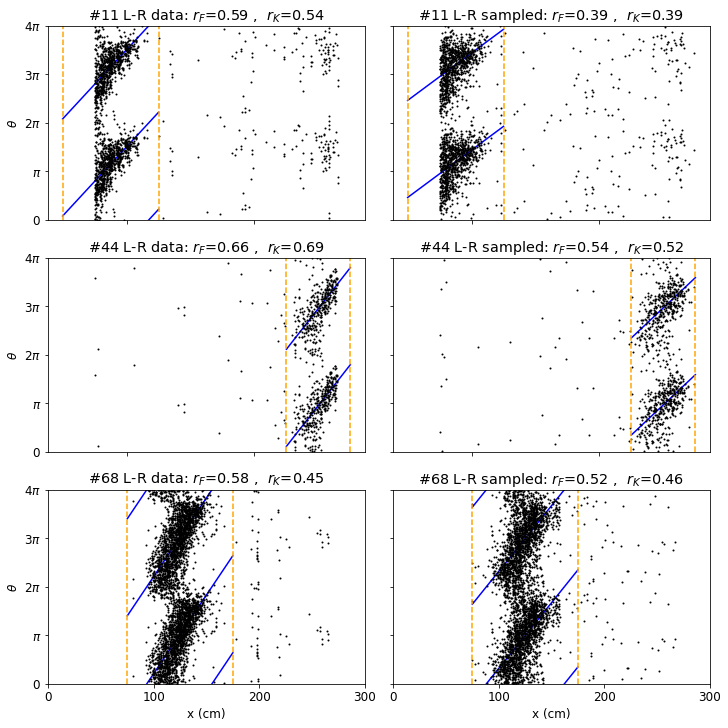

In [110]:
H, W = 3, 2
fig, ax = plt.subplots(H, W, squeeze=True, sharex=True, sharey=True, figsize=(10, 10),constrained_layout=True)

for i, nn in enumerate(selected_uu):
    # MUTUAL
    limit = lims_L_R[unit_used[nn]][0]
    x = np.linspace(limit[0], limit[1], 1000)
    
    # DATA/TRUE plot
    true_spikes = spk_count_L_R[nn].astype(bool)
    lim_true_spikes = spk_count_L_R[nn].astype(bool) & (rx_t_L_R > limit[0]) & (rx_t_L_R < limit[1])

    # Find regression line and plot it
    line, a, shift, losses = utils.latent.circ_lin_regression(rtheta_t_L_R[lim_true_spikes], rx_t_L_R[lim_true_spikes], dev='cpu', iters=1000, lr=1e-3)
    [ax[i, 0].plot(x, 2*np.pi*x*a + shift + k*2*np.pi, c='b') for k in range(-5,5)]
    print(a)

    # Plot spikes
    ax[i, 0].plot(rx_t_L_R[true_spikes], rtheta_t_L_R[true_spikes], 'o', ms=1, c='k')
    ax[i, 0].plot(rx_t_L_R[true_spikes], rtheta_t_L_R[true_spikes]+2*np.pi, 'o', ms=1, c='k')

    # Plot limits
    ax[i, 0].axvline(limit[0], ls='--', c='orange')
    ax[i, 0].axvline(limit[1], ls='--', c='orange')

    r_F_true = utils.stats.corr_lin_circ(rx_t_L_R[lim_true_spikes], rtheta_t_L_R[lim_true_spikes])
    r_K_true = utils.stats.corr_lin_circ_Kempter(rx_t_L_R[lim_true_spikes], rtheta_t_L_R[lim_true_spikes], a)

    ax[i, 0].set_ylim(0,4*np.pi)
    ax[i, 0].set_title(r'#{} L-R data: $r_F$={:.2f} ,  $r_K$={:.2f}'.format(unit_used[nn], r_F_true, r_K_true))

    # SAMPLED plot
    sampled_spikes = sampled_spktrain_L_R[nn].astype(bool)
    lim_sampled_spikes = sampled_spktrain_L_R[nn].astype(bool) & (rx_t_L_R > limit[0]) & (rx_t_L_R < limit[1])

    # Find regression line and plot it
    line, a, shift, losses = utils.latent.circ_lin_regression(rtheta_t_L_R[lim_sampled_spikes], rx_t_L_R[lim_sampled_spikes], dev='cpu', iters=1000, lr=1e-3)
    [ax[i, 1].plot(x, 2*np.pi*x*a + shift + k*2*np.pi, c='b') for k in range(-5,5)]
    print(a)

    # Plot spikes
    ax[i, 1].plot(rx_t_L_R[sampled_spikes], rtheta_t_L_R[sampled_spikes], 'o', ms=1, c='k')
    ax[i, 1].plot(rx_t_L_R[sampled_spikes], rtheta_t_L_R[sampled_spikes]+2*np.pi, 'o', ms=1, c='k')

    # Plot limits
    ax[i, 1].axvline(limit[0], ls='--', c='orange')
    ax[i, 1].axvline(limit[1], ls='--', c='orange')

    r_F_true = utils.stats.corr_lin_circ(rx_t_L_R[lim_sampled_spikes], rtheta_t_L_R[lim_sampled_spikes])
    r_K_true = utils.stats.corr_lin_circ_Kempter(rx_t_L_R[lim_sampled_spikes], rtheta_t_L_R[lim_sampled_spikes], a)

    ax[i, 1].set_ylim(0,4*np.pi)
    ax[i, 1].set_title(r'#{} L-R sampled: $r_F$={:.2f} ,  $r_K$={:.2f}'.format(unit_used[nn], r_F_true, r_K_true))


side = np.arange(H)
[ax[s, 0].set_ylabel(r'$\theta$') for s in np.arange(H)]
[ax[s, 0].set_yticks(np.arange(0, 4*np.pi+1e-3, np.pi))  for s in np.arange(H)]
[ax[s, 0].set_yticklabels([r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])  for s in np.arange(H)]
[ax[2, s].set_xlabel('x (cm)')  for s in np.arange(W)]
[ax[2, s].set_xticks(np.arange(0, 301, 100))  for s in np.arange(W)]

plt.show()

In [87]:
fig.savefig("output/spikes_corr_data_sampled_L_R.svg", bbox_inches='tight')

In [96]:
len(lims_L_R.keys())

16

In [98]:
# Data correlation values and slopes
a_data = []
r_F_data = []
r_K_data = []
for i, neuron in enumerate(unit_used):
    limit = lims_L_R[neuron][0]
    lim_true_spikes = spk_count_L_R[i].astype(bool) & (rx_t_L_R > limit[0]) & (rx_t_L_R < limit[1])

    line, a, shift, losses = utils.latent.circ_lin_regression(rtheta_t_L_R[lim_true_spikes], rx_t_L_R[lim_true_spikes], dev='cpu', iters=1000, lr=1e-3)
    r_F_true = utils.stats.corr_lin_circ(rx_t_L_R[lim_true_spikes], rtheta_t_L_R[lim_true_spikes])
    r_K_true = utils.stats.corr_lin_circ_Kempter(rx_t_L_R[lim_true_spikes], rtheta_t_L_R[lim_true_spikes], a)
    
    a_data.append(a)
    r_F_data.append(r_F_true)
    r_K_data.append(r_K_true)


change
change
change
change
change
change
change
change
change
change
change
change
change
change
change


In [ ]:
# need to add and compare the values for theta slope and correlation
# Generate spikes from GP
x = rx_t_L_R
theta = rtheta_t_L_R
covariates = [x, theta]
n_trials = 1
sampled_spktrain_L_R, rate, disp, discrete = glm_L_R.sample(covariates, np.zeros((n_trials,len(selected_uu)))) #, neuron=selected_uu)
sampled_spktrain_L_R = sampled_spktrain_L_R[0]

In [99]:
# Data correlation values and slopes
a_sampled = []
r_F_sampled = []
r_K_sampled = []
for i, neuron in enumerate(unit_used):
    limit = lims_L_R[neuron][0]
    lim_true_spikes = sampled_spktrain_L_R[i].astype(bool) & (rx_t_L_R > limit[0]) & (rx_t_L_R < limit[1])

    line, a, shift, losses = utils.latent.circ_lin_regression(rtheta_t_L_R[lim_true_spikes], rx_t_L_R[lim_true_spikes], dev='cpu', iters=1000, lr=1e-3)
    r_F = utils.stats.corr_lin_circ(rx_t_L_R[lim_true_spikes], rtheta_t_L_R[lim_true_spikes])
    r_K = utils.stats.corr_lin_circ_Kempter(rx_t_L_R[lim_true_spikes], rtheta_t_L_R[lim_true_spikes], a)
    
    a_sampled.append(a)
    r_F_sampled.append(r_F)
    r_K_sampled.append(r_F)

change
change
change
change
change
change
change
change
change
change
change
change
change
change
change


In [104]:
df = pd.DataFrame(np.array([a_data, a_sampled, r_F_data, r_F_sampled, r_K_data, r_K_sampled]).T, columns=['a_data', 'a_sampled', 'r_F_data', 'r_F_sampled', 'r_K_data', 'r_K_sampled'])
df.head()

,a_data,a_sampled,r_F_data,r_F_sampled,r_K_data,r_K_sampled
0,0.014247,0.009773,0.586608,0.386916,0.544024,0.386916
1,0.011953,-0.001222,0.452415,0.279865,0.043918,0.279865
2,0.021348,0.016953,0.533266,0.383551,0.536795,0.383551
3,0.003329,0.002383,0.300175,0.254816,0.062474,0.254816
4,-0.008907,-0.008233,0.351405,0.215753,0.132287,0.215753


In [107]:
(df['a_data'] - df['a_sampled']) / df['a_data']

0     0.313999
1     1.102239
2     0.205855
3     0.283943
4     0.075739
5     0.973401
6     0.262851
7     0.221077
8     1.698401
9    -0.137455
10    0.164751
11    0.034770
12   -0.260217
13   -0.079663
14    0.213292
dtype: float64

In [109]:
df[['a_data', 'a_sampled']]

,a_data,a_sampled
0,0.014247,0.009773
1,0.011953,-0.001222
2,0.021348,0.016953
3,0.003329,0.002383
4,-0.008907,-0.008233
5,0.008764,0.000233
6,0.016836,0.012410
7,0.020811,0.016210
8,-0.007239,0.005056
9,-0.004758,-0.005412
